# Recommendations Systems
## Assignment 2: Content Based Recommendations 

**By:**  
Group 8

<br><br>

**The goal of this assignment is to:**
- Understand the details of content based recommender systems
- Understand pros & cons comparing to other recommender system approaches
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ and up should be used.  
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).


**Grading:**
- Q1 - 10 points - Data exploration
- Q2 - 30 points - Item similarity
- Q3 - 40 points - Content based recommendation  
- Q4 - 20 points - Content based vs. matrix factorization comparison

`Total: 100`

**Prerequisites**

In [ ]:
!pip install --quiet zipfile36
!pip install --quiet wordcloud

**Imports**

In [ ]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from wordcloud import WordCloud, STOPWORDS

# metrics - do not use these metrics directly except for validating your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# distance
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [ ]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [ ]:
random.seed(123)
np.random.seed(124)

# Question 1: 
# Data exploration 

In this exercise you will use the same dataset that we used for exercise #1:  [MovieLens 100K rating dataset](https://grouplens.org/datasets/movielens/100k/)  use Fold #2

Include additional exploration that is relevant for content based recommendation:

Explore at least 3 features.  
For example, explore the genres, titles, and you may also use [IMDB's API](https://developer.imdb.com/documentation/api-documentation/) to include additional features.  
 
Use plots and discuss your insights and possible challenges related to the dataset.


## Taken from previous exercise

Download the MovieLens 100K rating dataset.   
 

In [ ]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

**Columns Names**

In [ ]:
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

**Read users data file**

In [ ]:
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_users.shape

(943, 5)

**Read items(movies) data file**

In [ ]:
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_items.shape

(1682, 24)

**Read rating data file**

In [ ]:
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
df_ratings.shape

(100000, 4)

Making sure shapes are mathing the info data file

In [ ]:
open(data_dir + 'u.info').readlines()

['943 users\n', '1682 items\n', '100000 ratings\n']

In [ ]:
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
ratings.head()

item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

item_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                              
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 1682 columns]

## Our Exploration

**Let's first have a quick look on the given datasets in order to get a first impression of their values**

In [ ]:
df_users.head()

user_id  age gender  occupation zip code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213

In [ ]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


In [ ]:
df_items.head()

movie id        movie_title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Childrens  ...  Fantasy  Film_Noir  Horror  Musical  \
0          0          1          1  ...        0          0       0        0   
1          1          0          0  ...        0          0       0        0   
2          0          0          0  ...        0          0       0        0   
3          0          0          0  ...        0          0       0        0   
4          0          0          0  ...        0          0       0        0   

   Mystery  Romance  Sci_Fi  Thriller  War  Western  
0        0        0       0         0    0        0  
1        0        0       0         1    0        0  
2        0        0       0         1    0        0  
3        0        0       0         0    0        0  
4        0        0       0         1    0        0  

[5 rows x 24 columns]

In [ ]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Childrens           1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film_Noir           1682 non-null   int64  
 16  Horror

In [ ]:
df_ratings.head()

user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [ ]:
from datetime import datetime
df_ratings_temp = df_ratings.copy()
df_ratings_temp['timestamp'] = df_ratings_temp['timestamp'].apply(datetime.fromtimestamp)
df_ratings_temp['year'] = df_ratings_temp['timestamp'].dt.year
df_ratings_temp['month'] = df_ratings_temp['timestamp'].dt.month
df_ratings_temp['date'] = df_ratings_temp['timestamp'].dt.date
df_ratings_temp

user_id  item_id  rating           timestamp  year  month        date
0          196      242       3 1997-12-04 15:55:49  1997     12  1997-12-04
1          186      302       3 1998-04-04 19:22:22  1998      4  1998-04-04
2           22      377       1 1997-11-07 07:18:36  1997     11  1997-11-07
3          244       51       2 1997-11-27 05:02:03  1997     11  1997-11-27
4          166      346       1 1998-02-02 05:33:16  1998      2  1998-02-02
...        ...      ...     ...                 ...   ...    ...         ...
99995      880      476       3 1997-11-22 05:10:44  1997     11  1997-11-22
99996      716      204       5 1997-11-17 19:39:03  1997     11  1997-11-17
99997      276     1090       1 1997-09-20 22:49:55  1997      9  1997-09-20
99998       13      225       2 1997-12-17 22:52:36  1997     12  1997-12-17
99999       12      203       3 1997-11-19 17:13:03  1997     11  1997-11-19

[100000 rows x 7 columns]

**Now, lets make some charts to visually compare multiple sets of data. These may help us to better understand the given data.**

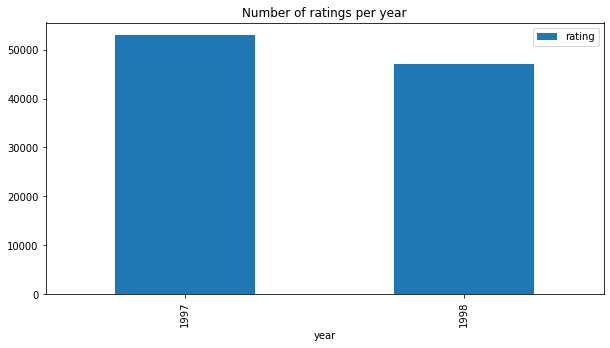

In [ ]:
df_ratings_temp[['year', 'rating']].groupby(['year']).count().reset_index().plot.bar(x='year', y='rating', title='Number of ratings per year', figsize=(10, 5));

**The ratings were collected over two years, which is not a long period**

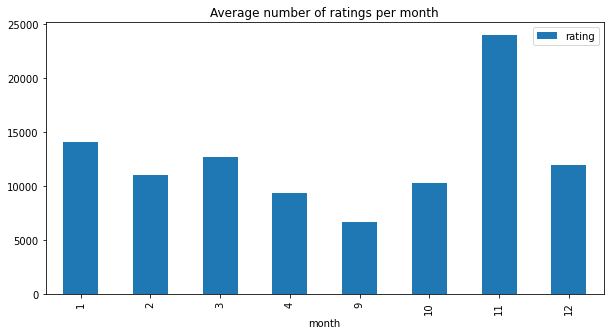

In [ ]:
df_ratings_month = df_ratings_temp[['month', 'rating']].groupby(['month']).count().reset_index()
df_ratings_month.plot.bar(x='month', y='rating', title='Average number of ratings per month', figsize=(10, 5));

**The ratings were not collected between the months of May and August, although we think it could be interesting to see the amount of ratings collected during the summer period**


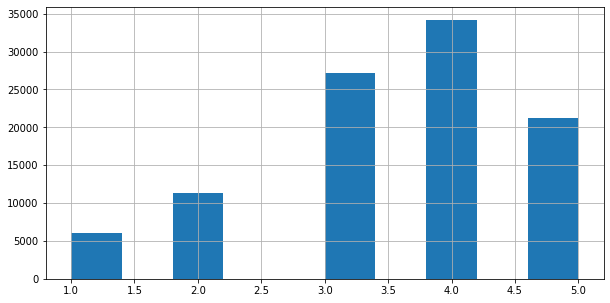

In [ ]:
df_ratings_temp['rating'].hist(figsize=(10, 5));

**Raters tend to give relatively high votes between 3 to 5**

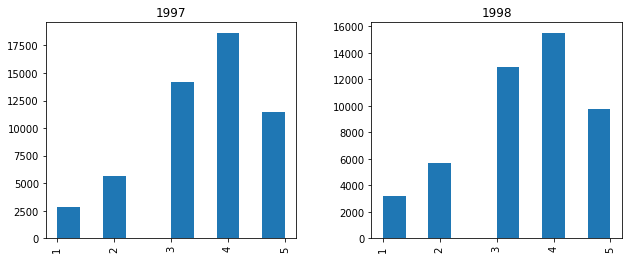

In [ ]:
df_ratings_temp['rating'].hist(by=df_ratings_temp['year'], figsize=(10, 4));

**The overall rating distribution is stable throughout the years**

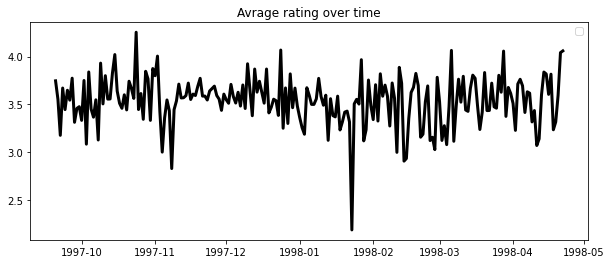

In [ ]:
df_temp = df_ratings_temp.groupby(['date'])['rating'].agg([np.mean, np.std]).reset_index()
plt.figure(figsize=(10,4)) 
plt.plot(df_temp['date'], df_temp['mean'], color="black", linewidth=3.0)
plt.title('Avrage rating over time')
plt.legend()
plt.show()

**The overall average rating is stable throughout their time**

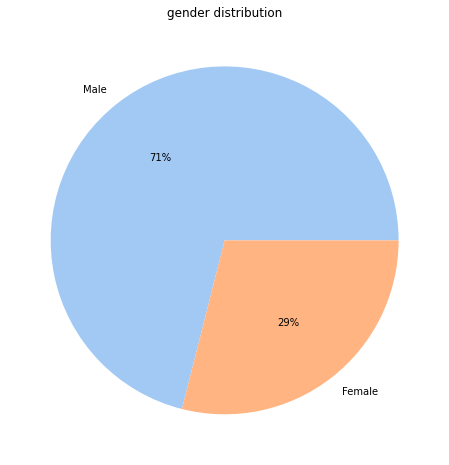

In [ ]:
plt.figure(figsize=(8,8)) 
plt.title('gender distribution')
data = [df_users[df_users['gender']=='M']['gender'].count(),df_users[df_users['gender']=='F']['gender'].count()]
labels= ['Male', 'Female']

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

data = [df_users[df_users['gender']=='M']['gender'].count(),df_users[df_users['gender']=='F']['gender'].count()]
labels= ['Male', 'Female']

**Most of the rates are Males**

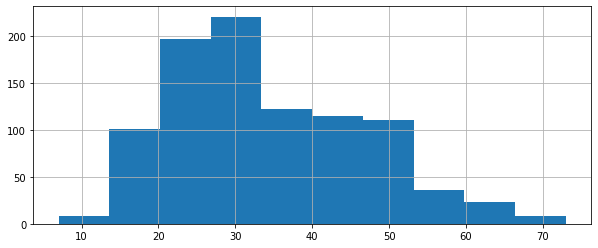

In [ ]:
plt.figure(figsize=(10,4)) 
df_users['age'].hist()

**Most of the raters are between the ages of 20 and 30**

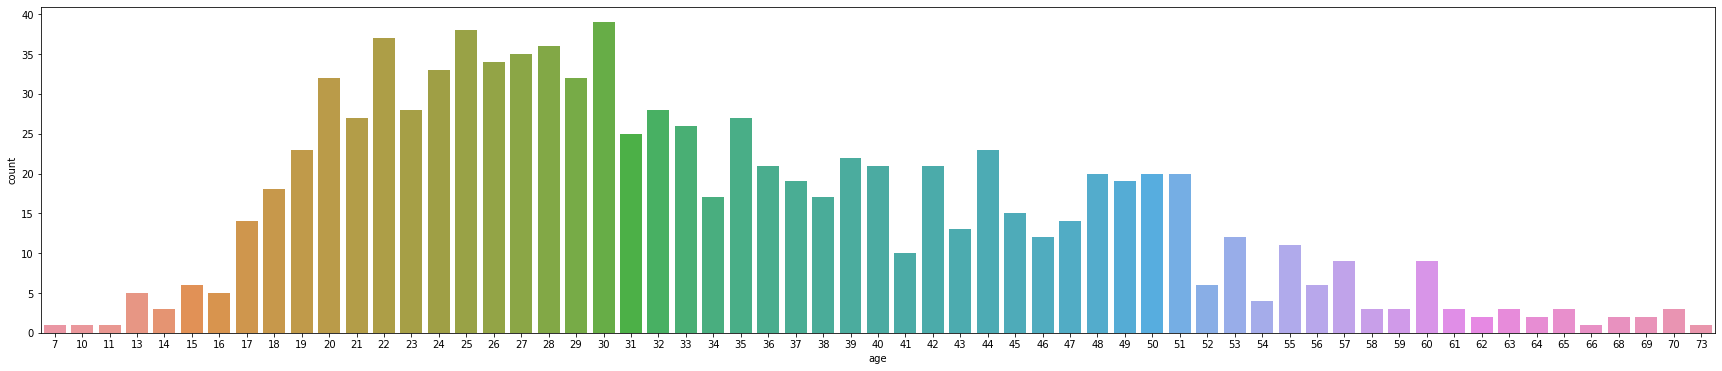

In [ ]:
plt.figure(figsize=(30,6))
sns.countplot(x = 'age' ,data = df_users)

**Indeed most of the raters are youngers, although it can be seen that a significant number of ratings were also made between the ages of 30 and 50**

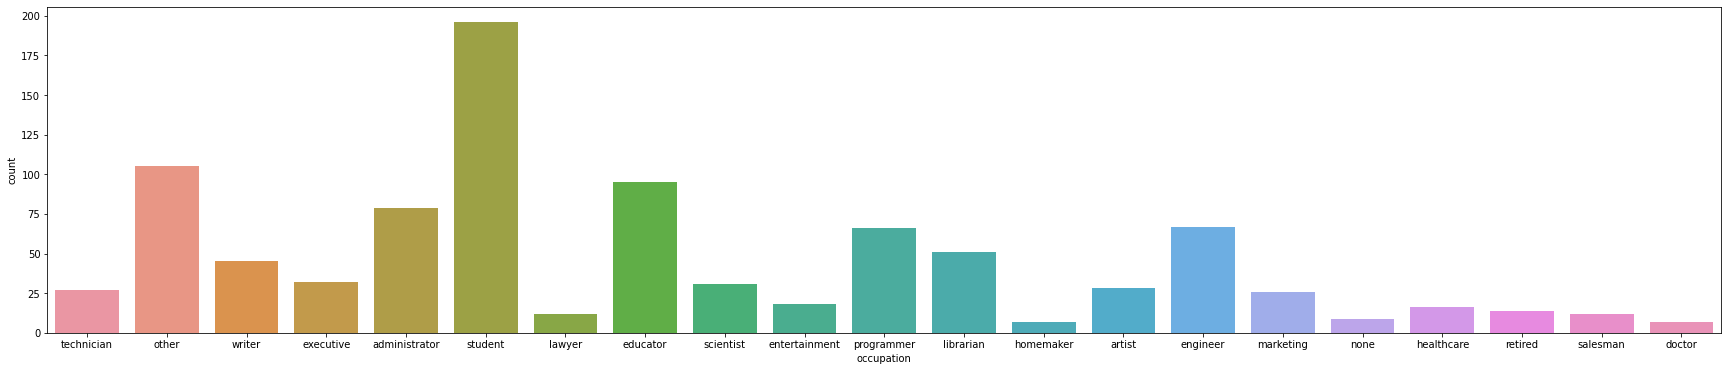

In [ ]:
plt.figure(figsize=(30,6))
sns.countplot(x = 'occupation' ,data = df_users)

**The leading profession among the raters is: students, which makes sense since we have seen that the majority of raters are young**


In [ ]:
generes_df = pd.DataFrame(df_items, columns = df_items.columns[5:])
generes_df.head()

unknown  Action  Adventure  Animation  Childrens  Comedy  Crime  \
0        0       0          0          1          1       1      0   
1        0       1          1          0          0       0      0   
2        0       0          0          0          0       0      0   
3        0       1          0          0          0       1      0   
4        0       0          0          0          0       0      1   

   Documentary  Drama  Fantasy  Film_Noir  Horror  Musical  Mystery  Romance  \
0            0      0        0          0       0        0        0        0   
1            0      0        0          0       0        0        0        0   
2            0      0        0          0       0        0        0        0   
3            0      1        0          0       0        0        0        0   
4            0      1        0          0       0        0        0        0   

   Sci_Fi  Thriller  War  Western  
0       0         0    0        0  
1       0         1    0        0  
2       0         1    0        0  
3       0         0    0        0  
4       0         1    0        0

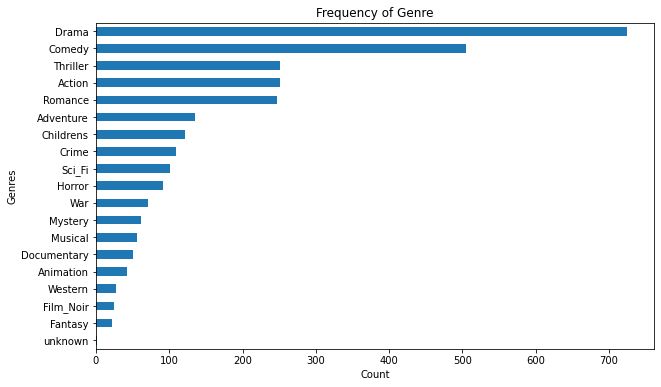

In [ ]:
result = np.sum(generes_df, axis=0)
plt.figure(figsize=(10,6))
result.sort_values()[-19:].plot(kind = 'barh', title = 'Frequency of Genre')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=20)
plt.show()

**Drama and Comedy are the most frequent genres**

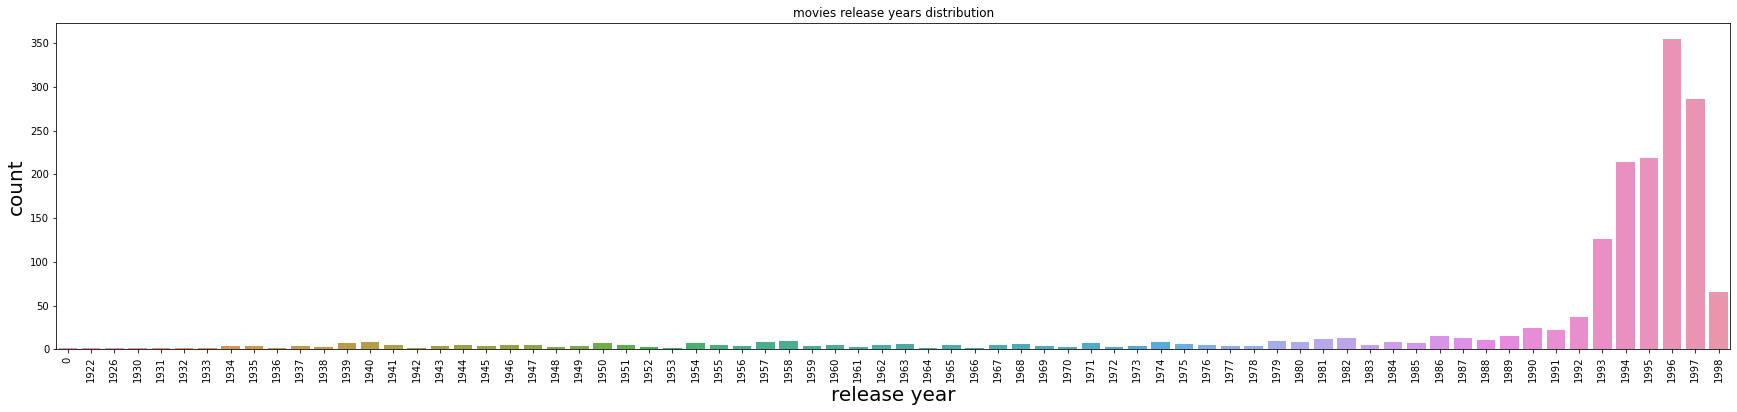

In [ ]:
plt.figure(figsize=(30,6))
df_temp = df_items.copy()
df_temp['release year'] = df_items['release_date'].str[-4:].fillna(0).astype('int')
plt.title('movies release years distribution')
plt.xticks(rotation = 90)
sns.countplot(x = df_temp['release year'])
plt.show()

**Most rated movies are from recent years**

In [ ]:
users_ratings_df = pd.merge(df_ratings,df_users,on='user_id')
users_ratings_df.rename(columns={'item_id': 'movie id'}, inplace=True)
users_ratings_items_df = pd.merge(users_ratings_df,df_items,on = 'movie id')
users_ratings_items_df

user_id  movie id  rating  timestamp  age gender  occupation zip code  \
0          196       242       3  881250949   49      M      writer    55105   
1          305       242       5  886307828   23      M  programmer    94086   
2            6       242       4  883268170   42      M   executive    98101   
3          234       242       4  891033261   60      M     retired    94702   
4           63       242       3  875747190   31      M   marketing    75240   
...        ...       ...     ...        ...  ...    ...         ...      ...   
99995      863      1679       3  889289491   17      M     student    60089   
99996      863      1678       1  889289570   17      M     student    60089   
99997      863      1680       2  889289570   17      M     student    60089   
99998      896      1681       3  887160722   28      M      writer    91505   
99999      916      1682       3  880845755   27      M    engineer    N2L5N   

                                     movie_title release_date  ...  Fantasy  \
0                                   Kolya (1996)  24-Jan-1997  ...        0   
1                                   Kolya (1996)  24-Jan-1997  ...        0   
2                                   Kolya (1996)  24-Jan-1997  ...        0   
3                                   Kolya (1996)  24-Jan-1997  ...        0   
4                                   Kolya (1996)  24-Jan-1997  ...        0   
...                                          ...          ...  ...      ...   
99995                           B. Monkey (1998)  06-Feb-1998  ...        0   
99996                          Mat' i syn (1997)  06-Feb-1998  ...        0   
99997                       Sliding Doors (1998)  01-Jan-1998  ...        0   
99998                        You So Crazy (1994)  01-Jan-1994  ...        0   
99999  Scream of Stone (Schrei aus Stein) (1991)  08-Mar-1996  ...        0   

      Film_Noir  Horror  Musical  Mystery  Romance  Sci_Fi  Thriller  War  \
0             0       0        0        0        0       0         0    0   
1             0       0        0        0        0       0         0    0   
2             0       0        0        0        0       0         0    0   
3             0       0        0        0        0       0         0    0   
4             0       0        0        0        0       0         0    0   
...         ...     ...      ...      ...      ...     ...       ...  ...   
99995         0       0        0        0        1       0         1    0   
99996         0       0        0        0        0       0         0    0   
99997         0       0        0        0        1       0         0    0   
99998         0       0        0        0        0       0         0    0   
99999         0       0        0        0        0       0         0    0   

       Western  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
99995        0  
99996        0  
99997        0  
99998        0  
99999        0  

[100000 rows x 31 columns]

**By merging all three dataframes to one, we can further explore the given data**

<Figure size 720x288 with 0 Axes>

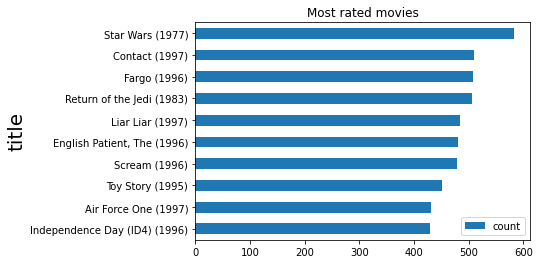

In [ ]:
plt.figure(figsize=(10,4)) 
top_titles = users_ratings_items_df['movie_title'].value_counts().nlargest(10)
top_titles_df = pd.DataFrame(top_titles.reset_index().values, columns=["title", "count"])
top_titles_df.sort_values(by='count').plot.barh(x='title', y='count')
plt.title("Most rated movies")
plt.show()

**This is logic, most rated titles are known movies**

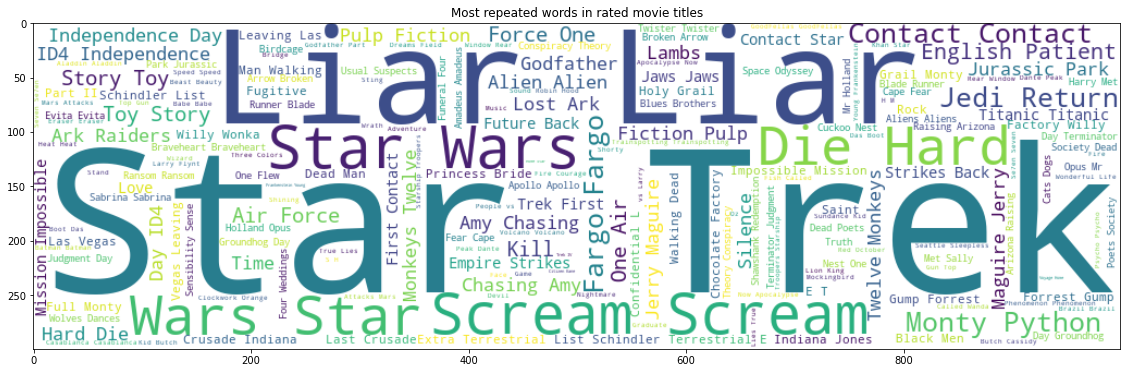

In [ ]:
plt.figure(figsize=(30,6)) 
titles_str = " ".join(x for x in users_ratings_items_df['movie_title'])
wordcloud = WordCloud(width=1000,height=300, max_font_size=200, background_color='white').generate(titles_str)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most repeated words in rated movie titles")
plt.show()

**Thats logic too, most repeated words are from known movie serieses**

## Taking fold 2

In [ ]:
df_folds = {i:
       {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter='\t', header=None, names=cols_data),
        'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter='\t', header=None, names=cols_data)
       } for i in range(1,6)} 

def fold2df(i):
    train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    return train,test 

def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test

fold = 2
train,test = getfulldf(*fold2df(fold))

train.shape,test.shape

((943, 1682), (943, 1682))

<br><br><br><br><br><br>
# Question 2:
# Item Similarity

The following blog posts [link1](https://medium.com/@bindhubalu/content-based-recommender-system-4db1b3de03e7), [link2](https://towardsdatascience.com/movie-recommendation-system-based-on-movielens-ef0df580cd0e), will be helpful for answering questions 2 and 3. 

Please provide code and explanations for your answer.  
In case you don't have a clear answer, please provide your best hypothesis.

### Build a movie profile vector based on the item features of your choice. 
Select at least two features from the dataset. Describe the potential contribution of each feature to a content based model.

Tip: When looking on the MovieLens dataset its features vector will include `genres`, `title`, etc.

In [ ]:
df_items.columns

Index(['movie id', 'movie_title', 'release_date', 'video_release_date',
       'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [ ]:
# example
irrelevant_cols = ['movie id', 'movie_title', 'release_date',
                   'video_release_date', 'IMDb_URL', 'unknown']
movies_profile = df_items.drop(irrelevant_cols,axis=1)

**Movie genres can provide valuable information about the content and style of a movie, which can be used to make more accurate and personalized recommendations to users. <br><br> The following features: movie id, movie title, url and unknown are not relevant. <br><br> We experimented with the release year (normalized) and also the release decade. We got recommended similar movies from the same time, however, after more thought we decided that this should not be a feature, as having the option to get similar movies from different times is desirable**



### Build a function which provides the 5 most similar items to an input item (item_id). 
Please use `Cosine Similarity` metric to calculate Item to item similarity.  
Notice: while it is a great way to debug your code, make sure not to return the actual input `item_id` in your results.


In [ ]:
def get_similar_items(movies_profile, item_id, n=5, include_self=False):
    ''' 
    item_id : target item 
    n : number of similar items to return
    
    This function returns a dataframe\array with ids of n most similar items to the target item and the similarity score
    '''

    idx = item_id - 1

    cos_sim_matrix = cosine_similarity(movies_profile)
    
    # So we don't return the actual input item_id
    cos_sim_matrix[idx, idx] = -1 

    item_vec = cos_sim_matrix[idx]

    most_similar_items_id = item_vec.argsort()[::-1][:n]
    most_similar_item_score = item_vec[most_similar_items_id]
    
    if include_self:
        most_similar_items_id = np.insert(most_similar_items_id, 0, idx)
        most_similar_item_score = np.insert(most_similar_item_score, 0, 1.0)
    
    return most_similar_items_id, most_similar_item_score

### Use the above function to find the 5 most similar items for any 2 items from the dataset. 
Please discuss the results you got. Are there any issues with the quality of the results? 

Please add the movie's title and image to your explanation.

In [ ]:
def get_similars_with_titles(movies_profile, item_id):
    idx, similarity_score = get_similar_items(movies_profile, item_id, include_self=True)

    irrelevant_cols = ['movie id', 'release_date', 'video_release_date',
                       'IMDb_URL', 'unknown']

    result = df_items.drop(irrelevant_cols, axis=1).iloc[idx]
    
    result['similarity_score'] = similarity_score
    
    return result

In [ ]:
import urllib

pics = pd.read_csv('https://raw.githubusercontent.com/ShopRunner/collie/main/data/movielens_posters.csv',
                   delimiter=',').set_index('item_id')
                   
def plot_pics(items : list,size = (12,6)):
    fig, ax = plt.subplots(1, len(items), figsize = size)
    for i, item in enumerate(items):
        ax[i].axis('off')
        ax[i].imshow(plt.imread(urllib.request.urlopen(pics.url.loc[item]), 0))
    fig.tight_layout()

In [ ]:
# first
toy_story = 1
toy_story_df = get_similars_with_titles(movies_profile, toy_story)
toy_story_df

movie_title  Action  Adventure  Animation  \
0                           Toy Story (1995)       0          0          1   
421   Aladdin and the King of Thieves (1996)       0          0          1   
1218                   Goofy Movie, A (1995)       0          0          1   
94                            Aladdin (1992)       0          0          1   
260                           Air Bud (1997)       0          0          0   
403                         Pinocchio (1940)       0          0          1   

      Childrens  Comedy  Crime  Documentary  Drama  Fantasy  Film_Noir  \
0             1       1      0            0      0        0          0   
421           1       1      0            0      0        0          0   
1218          1       1      0            0      0        0          0   
94            1       1      0            0      0        0          0   
260           1       1      0            0      0        0          0   
403           1       0      0            0      0        0          0   

      Horror  Musical  Mystery  Romance  Sci_Fi  Thriller  War  Western  \
0          0        0        0        0       0         0    0        0   
421        0        0        0        0       0         0    0        0   
1218       0        0        0        1       0         0    0        0   
94         0        1        0        0       0         0    0        0   
260        0        0        0        0       0         0    0        0   
403        0        0        0        0       0         0    0        0   

      similarity_score  
0             1.000000  
421           1.000000  
1218          0.866025  
94            0.866025  
260           0.816497  
403           0.816497

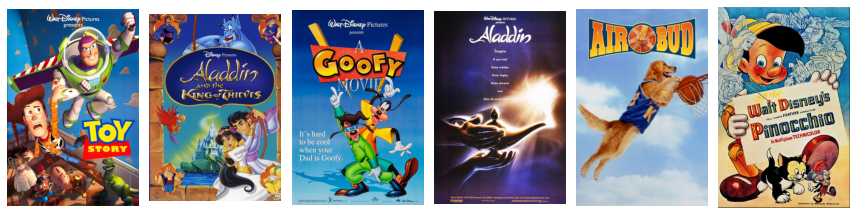

In [ ]:
plot_pics(toy_story_df.index + 1)

**This is logical, we would expect toy story to be similar to cartoons like Aladdin, Pinocchio, etc. and Air Bud is a Disney movie. All are children movies, mostly animated, very clearly similar to any one's point of view.**

**We can see that we don't have much variety with the similarity scores. This is due to the kind of feature vector we are using. This is a disadvantage of this algorithm**

In [ ]:
# second
golden_eye = 2
golden_eye_df = get_similars_with_titles(movies_profile, golden_eye)
golden_eye_df

movie_title  Action  Adventure  Animation  \
1                    GoldenEye (1995)       1          1          0   
826                   Daylight (1996)       1          1          0   
117                    Twister (1996)       1          1          0   
1015                   Con Air (1997)       1          1          0   
1012                  Anaconda (1997)       1          1          0   
565   Clear and Present Danger (1994)       1          1          0   

      Childrens  Comedy  Crime  Documentary  Drama  Fantasy  Film_Noir  \
1             0       0      0            0      0        0          0   
826           0       0      0            0      0        0          0   
117           0       0      0            0      0        0          0   
1015          0       0      0            0      0        0          0   
1012          0       0      0            0      0        0          0   
565           0       0      0            0      0        0          0   

      Horror  Musical  Mystery  Romance  Sci_Fi  Thriller  War  Western  \
1          0        0        0        0       0         1    0        0   
826        0        0        0        0       0         1    0        0   
117        0        0        0        0       0         1    0        0   
1015       0        0        0        0       0         1    0        0   
1012       0        0        0        0       0         1    0        0   
565        0        0        0        0       0         1    0        0   

      similarity_score  
1                  1.0  
826                1.0  
117                1.0  
1015               1.0  
1012               1.0  
565                1.0

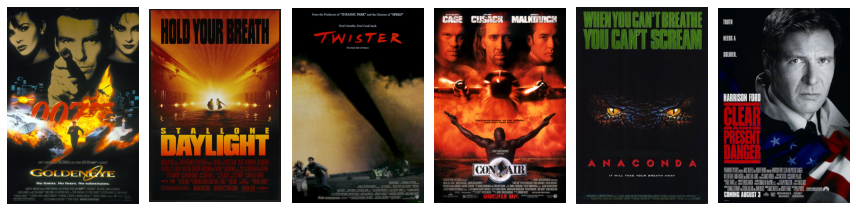

In [ ]:
plot_pics(golden_eye_df.index + 1)

**This is logical, we would expect a 007 movie to be similar to action movies like Con-Air, Clear and Present Danger, etc. They all have the exact same genres, hence, we get similarity score of 1.0 for all. Again this is an issue, where we don't have clear differentiation between the movies, as we only use genres.**

<br><br><br><br><br><br>
# Question 3:
# Content based recommendation



### Create Users Profile

In [ ]:
ratings = df_ratings.pivot(index='user_id', columns='item_id', values='rating')

idf = np.log(len(movies_profile) / movies_profile.sum())
movies_profile_tfidf = movies_profile.mul(idf, axis=1)

users_profile = ratings.apply(lambda x: movies_profile_tfidf.mul(x, axis=0).mean(axis=0), axis=1)

### Build a function which recommends n=5 most relevant items to a user. 

In [ ]:
def get_item_recommendations(users_profile, movies_profile, user_id, n=5):
    ''' 
    user_id: id of target user
    n : number of recommended items
    
    This function returns a dataframe\array with ids of n recommended items and their scores
    '''
    user_idx = user_id - 1

    cos_sim_matrix = cosine_similarity(users_profile,movies_profile)
    # So we don't return the actual input user_id
    cos_sim_matrix[user_idx, user_idx] = -1

    user_vec = cos_sim_matrix[user_idx]
    recommended_items_ids = user_vec.argsort()[::-1][:n]
    recommended_items_score = user_vec[recommended_items_ids]

    return recommended_items_ids, recommended_items_score
    

### Test your recommender system on 2 users. Explain your results.

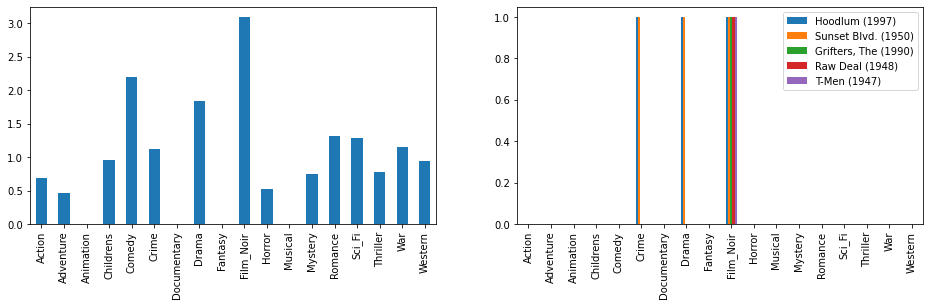

In [ ]:
# First User
user_id = 9
items, score = get_item_recommendations(users_profile,movies_profile,user_id)  

fig, axes = plt.subplots(ncols=2,figsize=(16,4))  
users_profile.loc[user_id].plot(kind='bar',ax=axes[0]) 
movies_profile.iloc[items].T.plot(kind='bar',ax=axes[1])  
plt.legend(df_items.loc[df_items.index.isin(items)].movie_title)
plt.show()

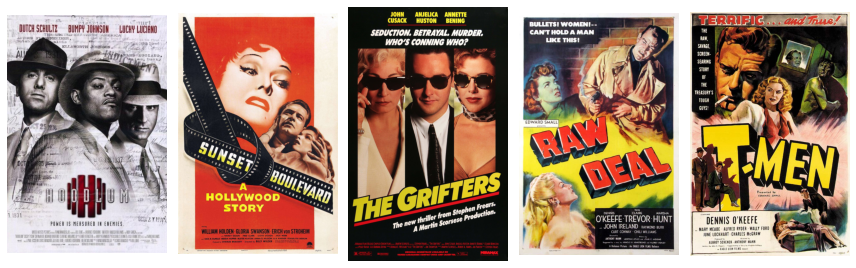

In [ ]:
plot_pics(df_items.loc[df_items.index.isin(items)]['movie id'])

**It is very clear that this user is into Film Noir movies that can also be Drama or Crime**

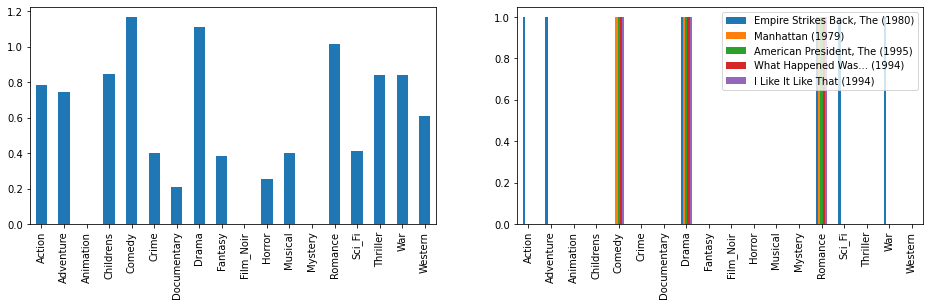

In [ ]:
# Second User
user_id = 68
items, score = get_item_recommendations(users_profile,movies_profile,user_id)  

fig, axes = plt.subplots(ncols=2,figsize=(16,4))  
users_profile.loc[user_id].plot(kind='bar',ax=axes[0]) 
movies_profile.iloc[items].T.plot(kind='bar',ax=axes[1])  
plt.legend(df_items.loc[df_items.index.isin(items)].movie_title)
plt.show()

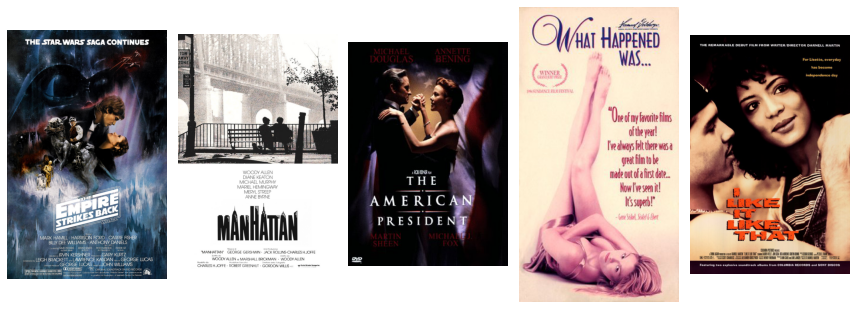

In [ ]:
plot_pics(df_items.loc[df_items.index.isin(items)]['movie id'])

**Looking at the charts on the right, we can see that films from similar genres were recommended, however, Star Wars seems to stand out as it has many other genres that the other films do not have. As this also uses user profiling, they all might be movies of a certain kind of taste. In this case there's no clear explanation as to why.**


### Use the MRR metric to evaluate your recommender system on the test set. 
Use a cutoff value of 5.

In [ ]:
class my_metrics():
        
    def RMSE(df_true,df_pred,lower_bound=1,upper_bound=5):
        # Mask all the zeros with Nan, so we don't count it towards the mean
        df_true = df_true.fillna(0)
        df_true = df_true.mask(df_true == 0)
        df_pred = df_pred.clip(lower_bound, upper_bound)
        rmse = np.mean(((df_pred - df_true) ** 2).stack()) ** .5
        return rmse
    
    
    def MRR(df_true,df_pred,lower_bound=1,upper_bound=5,threshold=3,top_n=5):
        df_true = df_true.fillna(0)
        df_pred = df_pred.clip(lower_bound, upper_bound)
        concated_df = pd.concat([df_true, df_pred], axis=1)
        users_rr = concated_df.apply(lambda x: my_metrics.MRR_for_user(x[:len(x)//2],
                                                                       x[len(x)//2:],
                                                                       threshold,
                                                                       top_n), axis=1)
        
        mrr = users_rr.mean()
        return mrr

    
    # def MRR_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5):
    def MRR_for_user(user_true,user_pred,threshold=3,top_n=5):
        user_true = user_true[user_true > 0]
        user_pred = user_pred.loc[user_true.index].reset_index(drop=True)

        user_true_relevancy = user_true >= threshold
        user_pred_top_n = user_pred.nlargest(top_n)
        relevancy_top_n = user_true_relevancy.reset_index(drop=True).loc[user_pred_top_n.index]

        # If none of the top n are relevant return reciprocal rank 0
        if relevancy_top_n.sum() == 0 or user_pred_top_n.iloc[0] < threshold:
            return 0
        
        reciprocal_rank = 1 / (np.argmax(relevancy_top_n) + 1)
        return reciprocal_rank

In [ ]:
final_results = pd.DataFrame(columns=['Method','Time','MRR_5'])

In [ ]:
start = time.time()

pred = pd.DataFrame().reindex_like(test).fillna(0)

users_rec = pred.apply(lambda x: get_item_recommendations(users_profile, movies_profile, x.name, -1), axis=1)
for i, (items, scores) in enumerate(users_rec, 1):
    pred.loc[i, items + 1] = scores

content_fit_time = time.time() - start

In [ ]:
final_results.loc[len(final_results)] = ['Content_Based', content_fit_time, my_metrics.MRR(test,pred.fillna(0),top_n=5,threshold=0.5)]

In [ ]:
final_results

Method      Time     MRR_5
0  Content_Based  8.506008  0.692471

<br><br><br><br><br>
# Question 4
# Content based recommendations vs. Matrix Factorization

### Use MF's  item representation to find the most similar items
Use the matrix factorization item representation you built in exercise 1 to find the most similar items for **the same 2 items** you used above. 
(Use your optimal hyperparams and resulting model)

Compare the results you got using the different methods below and discuss your findings

In [ ]:
class MF():
    
    def __init__(self,df_train,n_factors=10,only_bias=False):
        self.df_train = df_train
        self.R = df_train.values
        self.n_factors = n_factors
        self.only_bias = only_bias
        
        self.recommended = ratings.copy()
        self.recommended[:] = 0

        # rows==users , cols==items
        self.n_rows, self.n_cols = self.R.shape
        
        # biases
        self.original_bias_global = np.sum(self.R)/np.count_nonzero(self.R)
        self.original_bias_rows   = np.sum(self.R,axis=1)/np.count_nonzero(self.R,axis=1) 
        self.original_bias_cols   = np.sum(self.R,axis=0)/np.count_nonzero(self.R,axis=0)
        
        # "reset" initialization 
        self.initilize_params()
        
        
    def initilize_params(self):
        if self.only_bias:
            self.U = np.zeros((self.n_rows, self.n_factors))
            self.V = np.zeros((self.n_cols, self.n_factors))
        else:
            self.U = np.random.rand(self.n_rows, self.n_factors)
            self.V = np.random.rand(self.n_cols, self.n_factors)
        
        # initilize bias
        self.bias_global = self.original_bias_global   # no need to learn it
        self.bias_rows   = np.random.rand(self.n_rows) # random
        self.bias_cols   = np.random.rand(self.n_cols) # random
            
        
    def fit(self,
            n_iterations=1,
            learning_rate=1e-1,
            regularization=1e-2,
            convergence=1e-5,
            error='RMSE',
            initilize_training=True,
            verbose=True):
        
        start_time = time.time()

        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error
                  
        if initilize_training:
            self.initilize_params()

           
        # please record your progress in history
        self.history = []
                  
        # please record the training time in fit_time
        self.fit_time = None

        # please use the class functions 
        # for example(!) :

        for current_iteration in range(self.n_iterations):

            self.recommended = self.predict()

            # None ?
            self.history.append(self.get_rmse(self.df_train))
            
            # printing
            if verbose:
                print('iteration: ',current_iteration,' total error:\n',self.history[-1])
            
            # convergence
            if current_iteration!=0 and self.converging():
                
                if verbose:
                    print('converged...')
                break
            
            self.rows_indices = np.arange(self.n_rows)
            self.cols_indices = np.arange(self.n_cols)
            
            self.optim_GD()

        self.fit_time = time.time() - start_time  
    
    def converging(self):
        error_diff = self.history[-1] - self.history[-2]
        is_converged = np.abs(error_diff) < self.ϵ
        return is_converged

                  
    def optim_GD(self):
        # you can use np.dot,np.eye,np.linalg.solve,etc.
        for i, j in zip(self.rows_indices, self.cols_indices):

            error_i_j = self.get_error(i, j)
            
            if not self.only_bias:
                self.U[i] += self.α * ((error_i_j * self.V[j]) - (self.λ * self.U[i]))
                self.V[j] += self.α * ((error_i_j * self.U[i]) - (self.λ * self.V[j]))

            self.bias_rows[i] += self.α * (error_i_j - (self.λ * self.bias_rows[i]))
            self.bias_cols[j] += self.α * (error_i_j - (self.λ * self.bias_cols[j]))      

    def get_error(self, i, j):
        error = 0
        if self.R[i, j] == 0:
            return error
        error = self.R[i, j] - self.predict_entry(i, j)
        return error

    def predict_entry(self, i, j):
        bias = self.bias_global + self.bias_rows[i, np.newaxis] + self.bias_cols[np.newaxis, j]
        pred = np.dot(self.U[i], self.V[j].T) + bias
        return pred

    def predict(self, N=10):
        i = np.arange(self.n_rows)
        j = np.arange(self.n_cols)
        bias = self.bias_global + self.bias_rows[i, np.newaxis] + self.bias_cols[np.newaxis, j]
        pred = np.dot(self.U[i], self.V[j].T) + bias
        return pred

    def filter_empty_users(self, test):
        pred = self.recommended
        non_empty_users_test = test[test.sum(axis=1) > 0]
        non_empty_users_pred = pd.DataFrame(pred, index=self.df_train.index, columns=self.df_train.columns)
        non_empty_users_pred = non_empty_users_pred[test.sum(axis=1) > 0]
        return non_empty_users_test, non_empty_users_pred

    def get_rmse(self,test):
        non_empty_users_test, non_empty_users_pred = self.filter_empty_users(test)
        return my_metrics.RMSE(non_empty_users_test, non_empty_users_pred)

    def get_mrr(self,test,k=10,threshold=3):
        non_empty_users_test, non_empty_users_pred = self.filter_empty_users(test)
        return my_metrics.MRR(non_empty_users_test, non_empty_users_pred, 
                              top_n=k, threshold=threshold)

    def get_ndcg(self,test,k=5):
        non_empty_users_test, non_empty_users_pred = self.filter_empty_users(test)
        return my_metrics.NDCG(non_empty_users_test, non_empty_users_pred, 
                               top_n=k)

In [ ]:
n_iter = 20
conv = 1e-3
lf = 5
reg = 1
lr  = 0.1

results = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','History','Time'])

dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'Convergence':conv}

# initialize model
mf = MF(train,n_factors=lf)

# record training time
start = time.time()

# train MF
mf.fit(n_iterations=n_iter, convergence=conv, regularization=reg, learning_rate=lr, verbose=False)

# record traning time
dic['Time'] = time.time() - start

# eval model
# please use the model evaluation funcntions 
dic['RMSE'] = mf.get_rmse(test) 
dic['MRR_5'] = mf.get_mrr(test,k=5) 

# record model history
dic['History'] = mf.history # model 

# add experiment
results = results.append(dic,ignore_index=True)

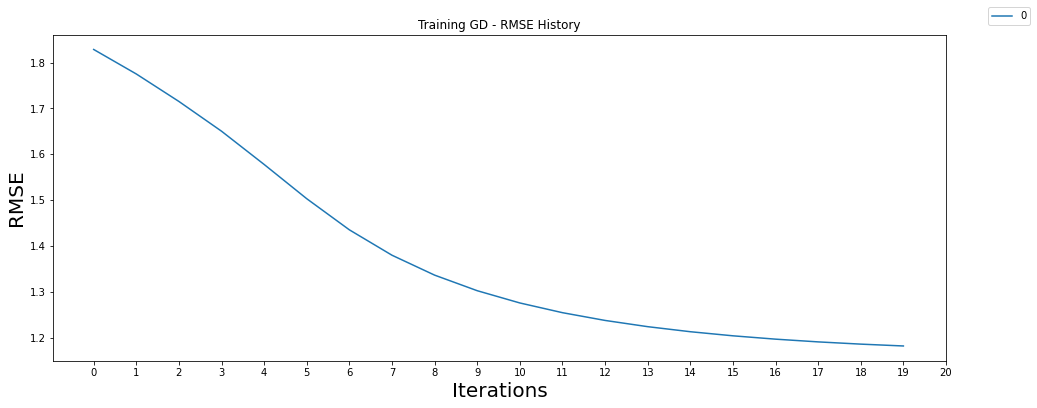

In [ ]:
lines = results.History

plt.figure(figsize=(16,6))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iter+1))
plt.legend(lines.index,loc='upper right',bbox_to_anchor=(1.1, 1.1))
plt.title('Training GD - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show();

**As we can see, the model has converged**


In [ ]:
final_results.loc[len(final_results)] = 'MF Model', dic['Time'], dic['MRR_5']

final_results

Method      Time     MRR_5
0  Content_Based  8.506008  0.692471
1       MF Model  4.386202  0.887085

In [ ]:
toy_story_mf_df = get_similars_with_titles(mf.V, toy_story)
toy_story_mf_df

movie_title  Action  Adventure  Animation  Childrens  \
0                Toy Story (1995)       0          0          1          1   
1472  Little Princess, The (1939)       0          0          0          1   
917         City of Angels (1998)       0          0          0          0   
997              Cabin Boy (1994)       0          0          0          0   
116              Rock, The (1996)       1          1          0          0   
894               Scream 2 (1997)       0          0          0          0   

      Comedy  Crime  Documentary  Drama  Fantasy  Film_Noir  Horror  Musical  \
0          1      0            0      0        0          0       0        0   
1472       0      0            0      1        0          0       0        0   
917        0      0            0      0        0          0       0        0   
997        1      0            0      0        0          0       0        0   
116        0      0            0      0        0          0       0        0   
894        0      0            0      0        0          0       1        0   

      Mystery  Romance  Sci_Fi  Thriller  War  Western  similarity_score  
0           0        0       0         0    0        0          1.000000  
1472        0        0       0         0    0        0          0.996293  
917         0        1       0         0    0        0          0.994736  
997         0        0       0         0    0        0          0.994454  
116         0        0       0         1    0        0          0.994449  
894         0        0       0         1    0        0          0.993738

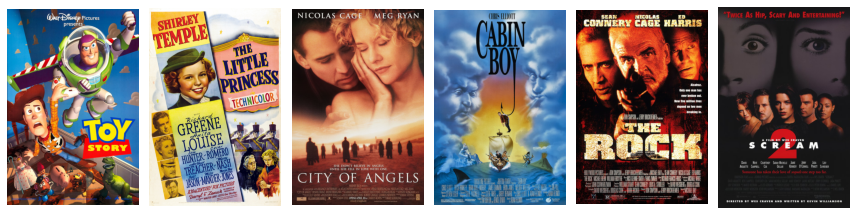

In [ ]:
plot_pics(toy_story_mf_df.index + 1)

**There is some logic, We would expect a Toy Stoy movie to be similar to youth movies such as The Little Princess and the Cabin Boy. However, it might be suprising that The Rock and Scream 2 were similar movies.**

In [ ]:
golden_eye_mf_df = get_similars_with_titles(mf.V, golden_eye)
golden_eye_mf_df

movie_title  Action  Adventure  Animation  Childrens  \
1               GoldenEye (1995)       1          1          0          0   
1593              Everest (1998)       0          0          0          0   
1618      All Things Fair (1996)       0          0          0          0   
1248    For Love or Money (1993)       0          0          0          0   
389   Fear of a Black Hat (1993)       0          0          0          0   
62      Santa Clause, The (1994)       0          0          0          1   

      Comedy  Crime  Documentary  Drama  Fantasy  Film_Noir  Horror  Musical  \
1          0      0            0      0        0          0       0        0   
1593       0      0            1      0        0          0       0        0   
1618       0      0            0      1        0          0       0        0   
1248       1      0            0      0        0          0       0        0   
389        1      0            0      0        0          0       0        0   
62         1      0            0      0        0          0       0        0   

      Mystery  Romance  Sci_Fi  Thriller  War  Western  similarity_score  
1           0        0       0         1    0        0          1.000000  
1593        0        0       0         0    0        0          0.996239  
1618        0        0       0         0    0        0          0.993124  
1248        0        0       0         0    0        0          0.988664  
389         0        0       0         0    0        0          0.987550  
62          0        0       0         0    0        0          0.984984

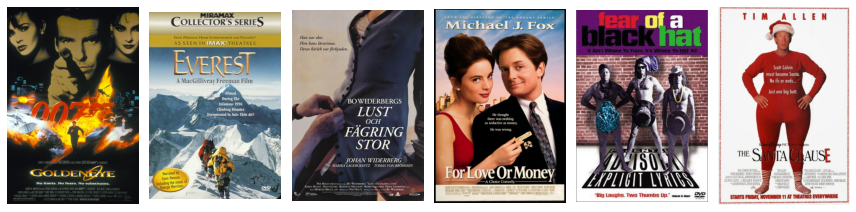

In [ ]:
plot_pics(golden_eye_mf_df.index + 1)

**There may be some logic as to why a 007 movie would be similar to Everest and For Love Or Money, however, it might be suprising that Fear of Black Hat and The Santa Clause were similar movies. <br><br><br> Overall, that is one of the cons of matrix factorization, explanibility is low since we are using latent vectors. However, if we're still trying to explain the given similarities, the results might suggest that matrix factorization provide a more diverse set of recommendations along with the obvious one.**

### Use MF implementation for item recommendations 

Use the matrix factorization implemention from exercise 1 to recommend 5 items to **the same 2 users** you used above. 
(Use your optimal hyperparams and resulting model)

Compare the results you got using the different methods. Discuss your findings

In [ ]:
def get_item_recommendations_mf(mf_model,user_id,n = 5):
    mf_df_filtered = mf_model.filter_empty_users(test)[1]
    idxs = mf_df_filtered.loc[user_id].nlargest(n).index
    mf_df_col = ['movie_title'] + movies_profile.columns.tolist()
    return idxs , df_items.loc[idxs][mf_df_col]

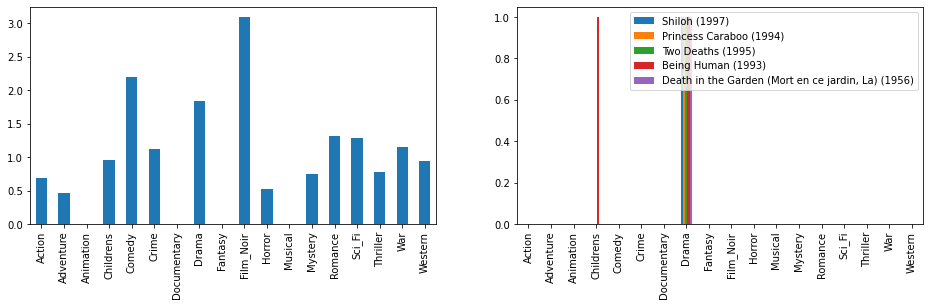

In [ ]:
# First User
user_id = 9
idxs, items = get_item_recommendations_mf(mf,user_id,n=5)  

fig, axes = plt.subplots(ncols=2,figsize=(16,4))  
users_profile.loc[user_id].plot(kind='bar',ax=axes[0]) 
movies_profile.iloc[idxs].T.plot(kind='bar',ax=axes[1])  
plt.legend(df_items.loc[df_items.index.isin(idxs)].movie_title)
plt.show()

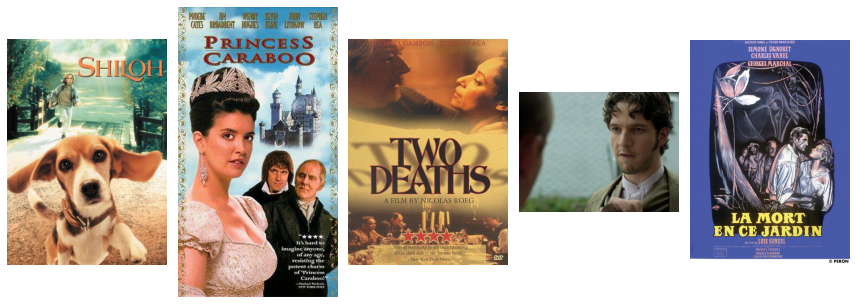

In [ ]:
plot_pics(df_items.loc[df_items.index.isin(idxs)]['movie id'])

**These user likes movies in the genre of drama, and he was indeed recommended movies of this type**

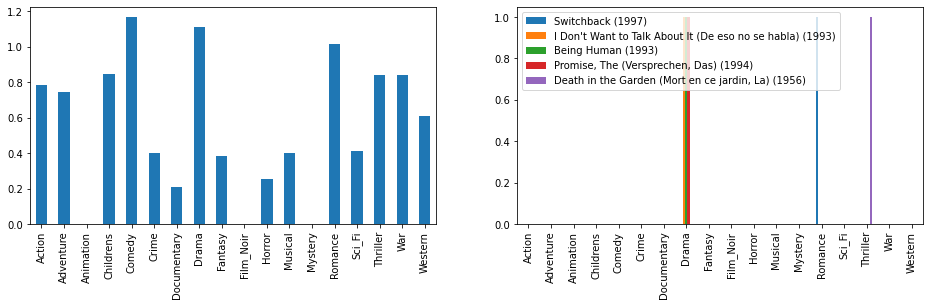

In [ ]:
# Second User
user_id = 68
idxs, items = get_item_recommendations_mf(mf,user_id,n=5)  

fig, axes = plt.subplots(ncols=2,figsize=(16,4))  
users_profile.loc[user_id].plot(kind='bar',ax=axes[0]) 
movies_profile.iloc[idxs].T.plot(kind='bar',ax=axes[1])  
plt.legend(df_items.loc[df_items.index.isin(idxs)].movie_title)
plt.show()

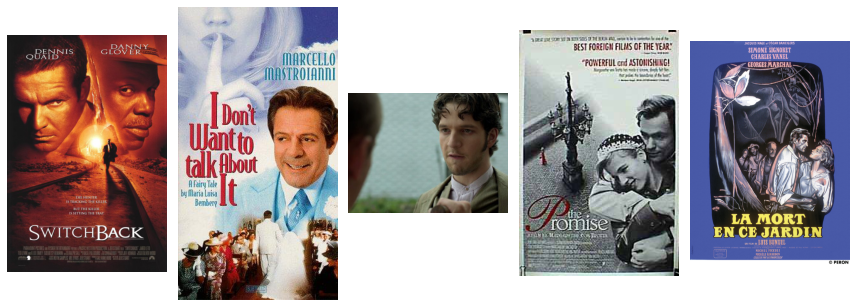

In [ ]:
plot_pics(df_items.loc[df_items.index.isin(idxs)]['movie id'])

**These users likes movies in the genre of drama and romance, and they was indeed recommended movies of this type**

**When comparing the results to the recommendations received for these users based on the content-based model, it can be concluded that under the content based model the recommendations were better adapted to the gener taste of the users. This is logic, since the content-based features composed directly by the genres, where the matrix factorization is not.**

### Compare the results of the content based recommender system to the matrix factorization recommender system

- Please use the same train and test set. 
- Please use the MRR metric for the comparison (provide a comparison plot). 

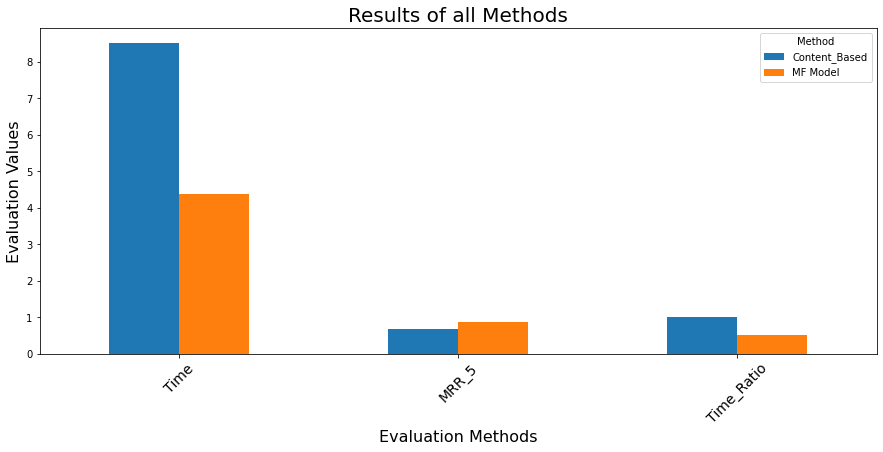

Time     MRR_5  Time_Ratio
Method                                       
Content_Based  8.506008  0.692471    1.000000
MF Model       4.386202  0.887085    0.515659

In [ ]:
final_results = final_results.set_index('Method')
final_results['Time_Ratio'] = final_results['Time']/final_results['Time'].max()

final_results.T.plot(kind="bar", figsize=(15,6))
plt.title("Results of all Methods", fontsize=20)
plt.xlabel("Evaluation Methods", fontsize=16)
plt.ylabel("Evaluation Values", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.show();

final_results

### Advantages & Disadvantages 

Please use the following table to discuss the advantages and disadvantages of matrix factorization vs. content based recommender systems.
Please address the following aspects in your discussion, and feel free to add your own.

**The content based model can make highly personalized recommendations based on the attributes of items and the preferences of the user. It's a scalable model since the choosen features are limited. The explainablity is high, since we can compare the meaningful features we've choosen. Also, it can make recommendations for new items that do not have any past interactions. However, It may requires some domain knowledge, along with storing and processing detailed information about each item. <br><br> Matrix factorization systems managed to achive really good results with no prior knowledge and preperation. However, it may struggle to make recommendations for users with very few past interactions, as they rely on a sufficient amount of data to learn the low-dimensional representation of the user-item interactions. Also, it is less scalable since the dimensionality depends on the given number of items and users. Finally, it's explainability is low, since we're using a latent vectors with no explicit meanings. <br><br> In the bottom line, matrix factorization would be a good choice if we want high accuracy, and if we are not interested in performing feature engineering on our own. On the other hand, a content based model will be a good choice when we want a scalable and explainable model. Finally, if we want to enjoy both worlds, we might want to use a hybrid model of these two.**

<table>
    <thead>
        <tr>
            <th>..</th>
            <th style="text-align:center">Content-Based</th>
            <th style="text-align:center">Matrix-Factorization</th>
            <th style="text-align:left">Notes:</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Dimensionality</td>
            <td style="text-align:center">Limited</td>
            <td style="text-align:center">Unlimited</td>
            <td style="text-align:left">Content-based limited by the choosen features, matrix factorization is unlimited based on the number of items</td>
        </tr>
        <tr>
            <td>Similarity</td>
            <td style="text-align:center">By content features</td>
            <td style="text-align:center">By latent vectors and ratings</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Accuracy</td>
            <td style="text-align:center">Medium</td>
            <td style="text-align:center">High</td>
            <td style="text-align:left">Based on the above findings where we compared the two models</td>
        </tr>
        <tr>
            <td>Tranining Complexity</td>
            <td style="text-align:center">O(m)</td>
            <td style="text-align:center">O(n*m) quite complex</td>
            <td style="text-align:left">Where m is the number of items and n is the numer of users</td>
        </tr>
        <tr>
            <td>Inference Complexity</td>
            <td style="text-align:center">Fast</td>
            <td style="text-align:center">Fast</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Explanability</td>
            <td style="text-align:center">High</td>
            <td style="text-align:center">Low</td>
            <td style="text-align:left">Content based with meaningful features, matrix factorization with latent vectors</td>
        </tr>
        <tr>
            <td>Scalability</td>
            <td style="text-align:center">High</td>
            <td style="text-align:center">Low</td>
            <td style="text-align:left">Matrix factorization become more complex as the number of users and items increase</td>
        </tr>        
        <tr>
            <td>New User</td>
            <td style="text-align:center">Cold Start Problem Exist</td>
            <td style="text-align:center">Cold Start Problem Exist</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>New Item</td>
            <td style="text-align:center">Cold Start Problem Solved</td>
            <td style="text-align:center">Cold Start Problem Exist</td>
            <td style="text-align:left">In content based, cold start problem solved because we can compare new item based on his features</td>
        </tr>
        <tr>
            <td>Train Time</td>
            <td style="text-align:center">Fast</td>
            <td style="text-align:center">Increase by the given dimensionality</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Predict Time</td>
            <td style="text-align:center">Fast</td>
            <td style="text-align:center">Fast</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Deterministic</td>
            <td style="text-align:center">Yes</td>
            <td style="text-align:center">No</td>
            <td style="text-align:left">Matrix factorization result will differ in every experiment</td>
        </tr>
    </tbody>
</table>

<br>

Good Luck :)